In [3]:
import zipfile
import os

zip_path = "/content/Pothole.v1-raw.yolov5pytorch.zip"   # <-- change if name is different
extract_path = "dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)


['data.yaml',
 'README.dataset.txt',
 'test',
 'README.roboflow.txt',
 'valid',
 'train']

In [4]:
for split in ["train", "valid", "test"]:
    print(f"\n{split.upper()}")
    print(os.listdir(f"dataset/{split}"))



TRAIN
['labels', 'images']

VALID
['labels', 'images']

TEST
['labels', 'images']


In [5]:
def count_files(path):
    return len([f for f in os.listdir(path) if f.endswith(('.jpg','.png','.jpeg'))])

for split in ["train", "valid", "test"]:
    img_count = count_files(f"dataset/{split}/images")
    lbl_count = len(os.listdir(f"dataset/{split}/labels"))
    print(f"{split}: images={img_count}, labels={lbl_count}")


train: images=465, labels=465
valid: images=133, labels=133
test: images=67, labels=67


In [6]:
label_file = os.listdir("dataset/train/labels")[0]

with open(f"dataset/train/labels/{label_file}", "r") as f:
    print(f.read())


0 0.42257462686567165 0.81 0.6026119402985075 0.37333333333333335


(np.float64(-0.5), np.float64(449.5), np.float64(299.5), np.float64(-0.5))

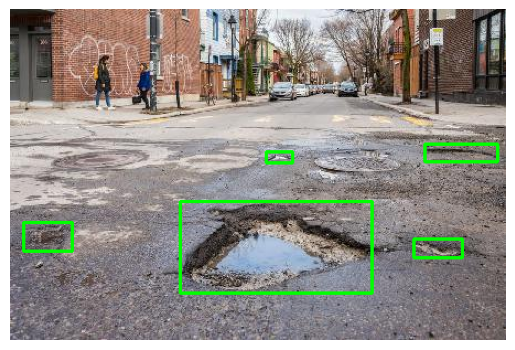

In [14]:
import cv2
import matplotlib.pyplot as plt
import os

img_name = os.listdir("dataset/train/images")[0]
img_path = f"dataset/train/images/{img_name}"

label_name = os.path.splitext(img_name)[0] + ".txt"
lbl_path = f"dataset/train/labels/{label_name}"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, _ = img.shape

with open(lbl_path) as f:
    for line in f:
        cls, xc, yc, bw, bh = map(float, line.split())
        x1 = int((xc - bw/2) * w)
        y1 = int((yc - bh/2) * h)
        x2 = int((xc + bw/2) * w)
        y2 = int((yc + bh/2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

plt.imshow(img)
plt.axis("off")


In [15]:
with open("dataset/data.yaml") as f:
    print(f.read())


train: ../train/images
val: ../valid/images

nc: 1
names: ['pothole']


In [16]:
!pip -q install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.5 MB/s eta 0:00:00


In [17]:
from ultralytics import YOLO
import ultralytics
ultralytics.__version__


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


'8.4.9'

In [18]:
with open("dataset/data.yaml") as f:
    print(f.read())


train: ../train/images
val: ../valid/images

nc: 1
names: ['pothole']


In [19]:
import yaml

yaml_path = "dataset/data.yaml"

with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)

# force correct paths
data["path"] = "dataset"
data["train"] = "train/images"
data["val"]   = "valid/images"
data["test"]  = "test/images"

with open(yaml_path, "w") as f:
    yaml.dump(data, f, sort_keys=False)

with open(yaml_path, "r") as f:
    print(f.read())


train: train/images
val: valid/images
nc: 1
names:
- pothole
path: dataset
test: test/images



In [20]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # pre-trained on COCO

results = model.train(
    data="dataset/data.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    device=0
)


Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

In [21]:
import os
os.listdir("runs/detect")

['train']

In [22]:
import glob

best_paths = glob.glob("runs/detect/**/weights/best.pt", recursive=True)
best_paths


['runs/detect/train/weights/best.pt']

In [23]:
best_model_path = best_paths[-1]
best_model_path


'runs/detect/train/weights/best.pt'

In [24]:
from ultralytics import YOLO
import os, random

model = YOLO(best_model_path)

test_dir = "dataset/test/images"
test_imgs = random.sample(os.listdir(test_dir), k=min(5, len(os.listdir(test_dir))))

results = model.predict(
    source=[os.path.join(test_dir, x) for x in test_imgs],
    imgsz=640,
    conf=0.25,
    save=True
)

print("Saved predictions to:", results[0].save_dir)



0: 640x640 2 potholes, 9.6ms
1: 640x640 3 potholes, 9.6ms
2: 640x640 2 potholes, 9.6ms
3: 640x640 1 pothole, 9.6ms
4: 640x640 1 pothole, 9.6ms
Speed: 3.1ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict
Saved predictions to: /content/runs/detect/predict


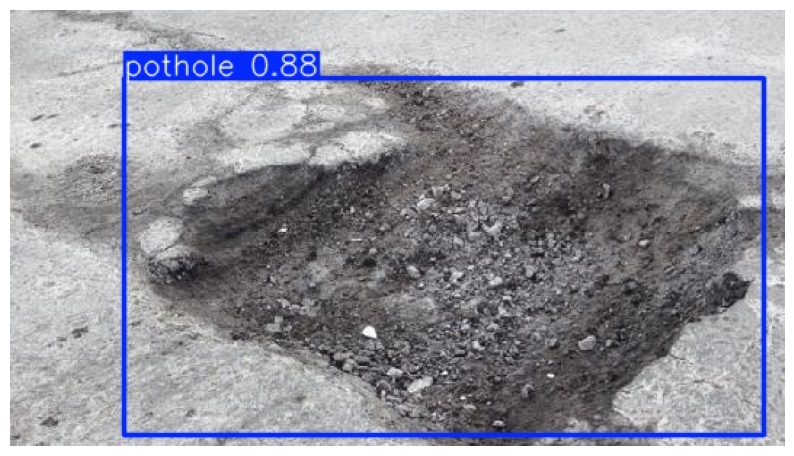

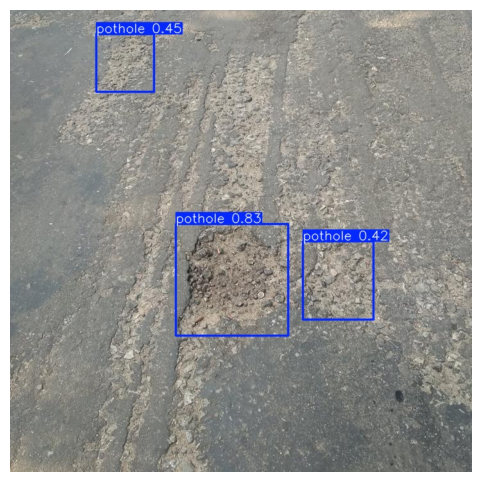

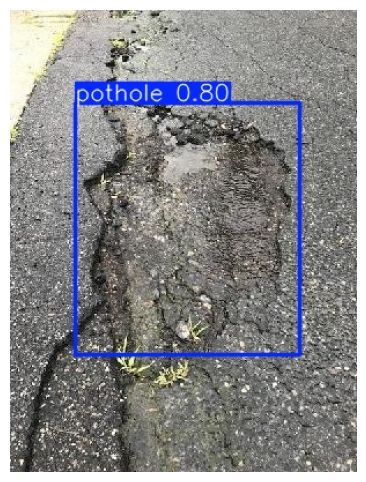

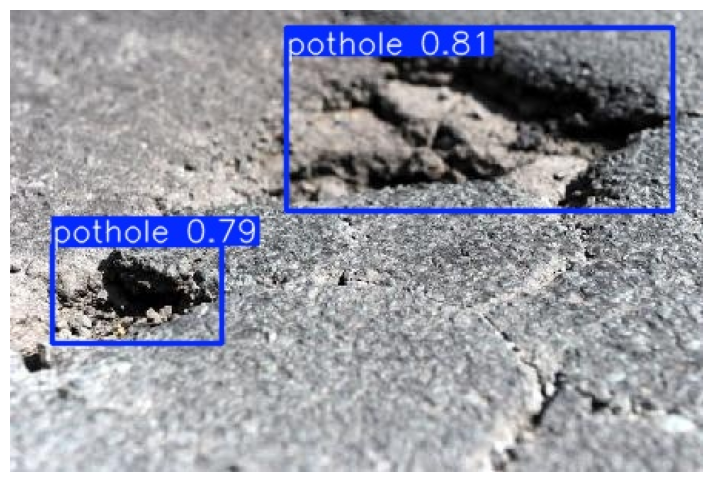

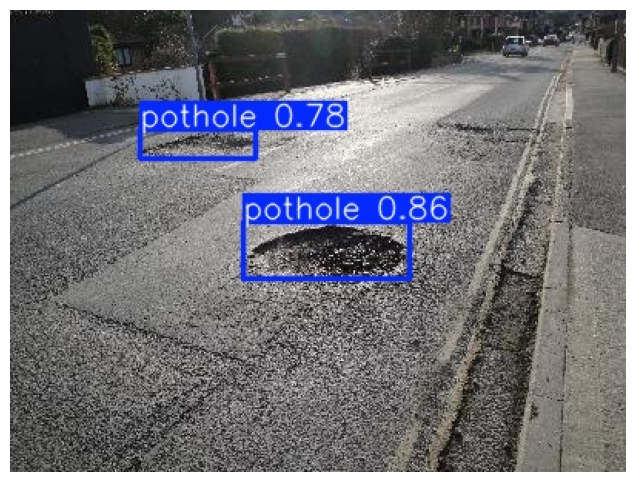

In [25]:
import matplotlib.pyplot as plt
import cv2
import glob

pred_dir = str(results[0].save_dir)
pred_imgs = glob.glob(pred_dir + "/*.jpg") + glob.glob(pred_dir + "/*.png")

for p in pred_imgs[:5]:
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [26]:
import os, shutil

os.makedirs("model", exist_ok=True)
shutil.copy(best_model_path, "model/best.pt")
print("Saved:", "model/best.pt")


Saved: model/best.pt
